In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import MultivariateNormalDataset, HUNCCInputDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)

In [ ]:
import random
xor_key = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
data_X= np.tile(2,(100000, 16)) #100,000 samples each with a length of 16 for plaintext
data_Y= np.tile(2,(100000, 16)) #100,000 samples each with a length of 16 for ciphertext

#run your cryptosystem here so that data_X is the plaintext, data_Y is the ciphertext. modify size if necessary
    

Device: cuda
Testing: 100%|██████████| 10/10 [00:01<00:00,  9.00batch/s]
MINE 0.0785704180598259
50000


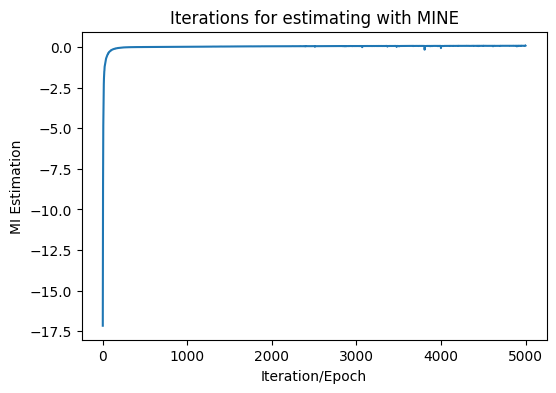

In [3]:

%load_ext autoreload
%autoreload 2
from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)

x_dim = 16 #plaintext length of a single sample
z_dim = 16 #ciphertext length of a single sample
N = 99999 # num samples -1
lr = 1e-4 #learning rate
epochs = 5000 #epochs
batch_size = 10000 #batch size


#format data
loss_type = ['mine']
_X = torch.tensor(data_X)
X = _X.type('torch.FloatTensor') 
_Y= torch.tensor(data_Y)
Y = _Y.type('torch.FloatTensor') 
    
    
for loss in loss_type:
        
    train_loader = torch.utils.data.DataLoader(
    HUNCCInputDataset(N, X, Y, x_dim, z_dim), batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
    HUNCCInputDataset(N, X, Y, x_dim, z_dim), batch_size=batch_size, shuffle=False)

    #train data = test data, we can overfit to the cryptosystem doesnt matter for our purposes. use train data to visualize data anyway

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
            x_dim, z_dim, loss=loss, **kwargs).to(device)

    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    trainer.fit(model)
    trainer.test()

    print("MINE {}".format(model.avg_test_mi))
    

In [ ]:
#show learning curve on a plot

iteration_array = model.raw_data2

data_array2 = []

# here the number is 10 since samples is 100,00 and batch size is 10,00. so 10 estimations per epoch. we take the average

for i in range(10,len(iteration_array),10):
    sum1 = 0
    for j in range(10):
        sum1+=iteration_array[i+j][1]
    data_array2.append((i/10,sum1/10))
    
data_array2 = np.array(data_array2)
data_array2.astype(float)

fig2, axs = plt.subplots(1, len(loss_type), sharex = True, figsize = (6,4))
plots = []
plots += axs.plot(data_array2[:,0], data_array2[:,1], label='MI')

axs.set_xlabel('Iteration/Epoch')
axs.set_ylabel('MI Estimation')
axs.title.set_text(f"Iterations for estimating with MINE")
